### Import

In [67]:
import numpy as np
import math
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from numpy.linalg import qr, norm
import open3d as o3d

In [ ]:
import numpy as np

x = np.asarray([-1, 0, 1, 1])
y = np.asarray([1, -2, -3, 3])
z = np.asarray([2, 2, 5, 2])
l, m, n = [2, 2, 2]
deg = [l, m, n]
V = np.polynomial.polynomial.polyvander3d(x=x, y=y, z=z, deg=deg)
# print(V, V.shape)

x = np.linspace(-1, 1, 10)
n = 4
from scipy.special import chebyt
# output chebyshev polynomial of the first kind
print(np.allclose(np.cos(n * np.arccos(x)), chebyt(n)(x)))

from scipy.special import legendre
# output legendre polynomial
# the formula of legendre poly:
# P_n(x) = (1/(2^n * n!)) * d^n/dx^n[(x^2 - 1)^n]
# P_0(x) = 1
# P_1(x) = x
# P_2(x) = 1/2 * (3x^2 - 1)
# P_3(x) = 1/2 * (5x^3 - 3x)
# P_4(x) = 1/8 * (35x^4 - 30x^2 + 3)
print(np.allclose(legendre(4)(x), 1/8 * (35 * x**4 - 30 * x**2 + 3)))

from scipy.special import hermitenorm
# output hermite polynomial
# the formula of hermite poly:
# H_n(x) = (-1)^n * exp(x^2 / 2) * d^n/dx^n(exp(-x^2 / 2))

print(hermitenorm(5)(x))
print(np.allclose(hermitenorm(5)(x), ((x**5 - 10 * x**3 + 15 * x))))

from scipy.special import laguerre
# output laguerre polynomial
# the formula of laguerre poly:
# L_n(x) = exp(x) * d^n/dx^n(x^n * exp(-x))
print(laguerre(5)(x))
print(np.allclose(laguerre(5)(x), 1/120 * (-x**5 + 25 * x**4 - 200 * x**3 + 600 * x**2 - 600 * x + 120)))

0.0 9.0
jk_pairs 13 [(0, 0), (1, 1), (1, -1), (2, 1), (2, 3), (2, -1), (2, -3), (3, 1), (3, 3), (3, 5), (3, -1), (3, -3), (3, -5)]


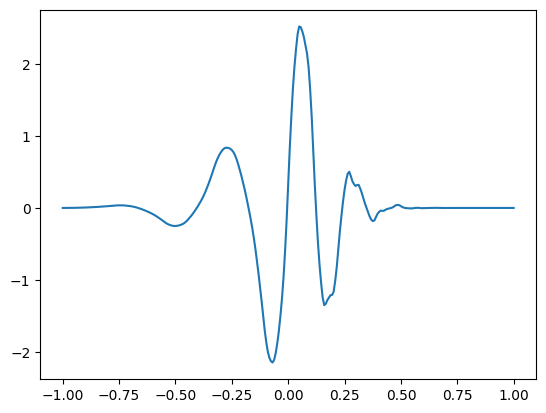

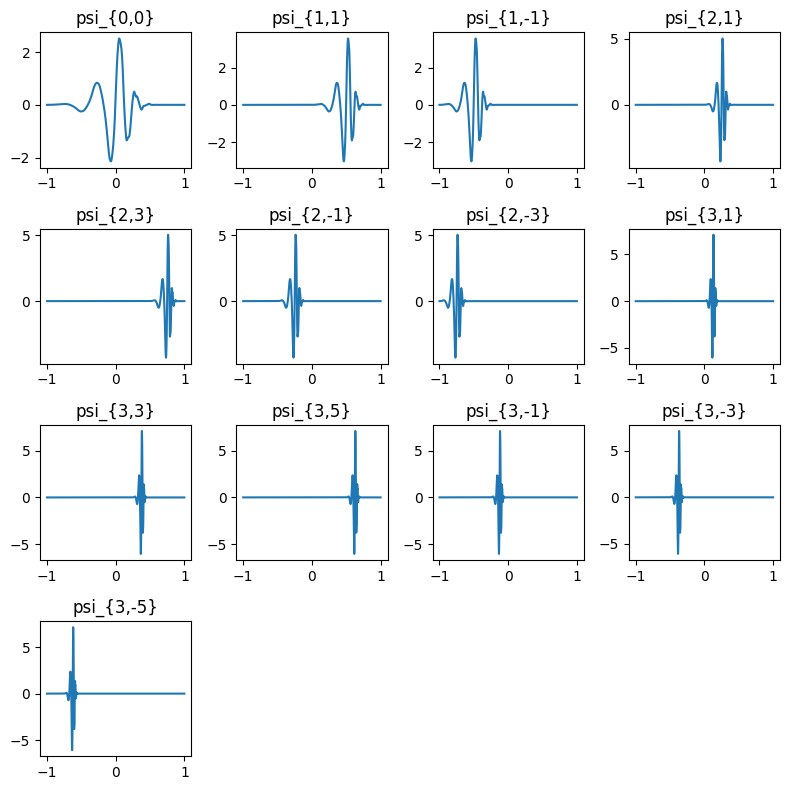

Inner product <psi_{0,0}, psi_{0,0}> = 0.9956394177396268
Inner product <psi_{1,1}, psi_{1,1}> = 0.9956339319379689
Inner product <psi_{1,-1}, psi_{1,-1}> = 0.9956339319379688
Inner product <psi_{2,1}, psi_{2,1}> = 0.9954361914125565
Inner product <psi_{2,3}, psi_{2,3}> = 0.9954361914125566
Inner product <psi_{2,-1}, psi_{2,-1}> = 0.9954361914125566
Inner product <psi_{2,-3}, psi_{2,-3}> = 0.9954361914125566
Inner product <psi_{3,1}, psi_{3,1}> = 0.9960758649562056
Inner product <psi_{3,3}, psi_{3,3}> = 0.9960758649562055
Inner product <psi_{3,5}, psi_{3,5}> = 0.9960758649562055
Inner product <psi_{3,-1}, psi_{3,-1}> = 0.9960758649562054
Inner product <psi_{3,-3}, psi_{3,-3}> = 0.9960758649562054
Inner product <psi_{3,-5}, psi_{3,-5}> = 0.9960758649562054


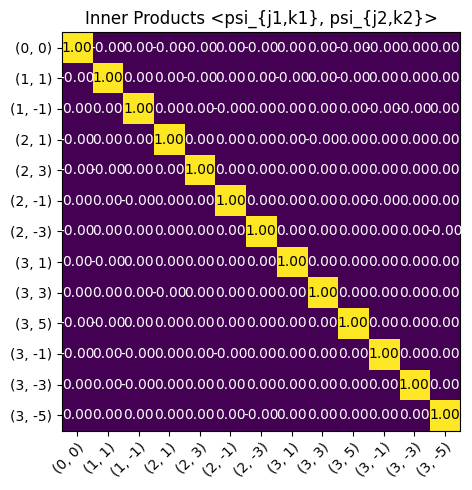

In [82]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
from scipy.integrate import simpson

def psi_jk(t, base_psi, base_x, j, k):
    """
    Construct the wavelet function psi_{j,k}(t) = 2^(j/2) * psi(2^j * t - k).
    
    :param t: array of time points where we want to evaluate psi_{j,k}(t).
    :param base_psi: array of the base wavelet samples (psi) from pywt.Wavelet.wavefun().
    :param base_x: array of x-values corresponding to base_psi.
    :param j: integer scale.
    :param k: integer shift.
    :return: array of psi_{j,k}(t) values.
    """
    # We need to map from t -> (2^j * t - k), then interpolate base_psi, base_x
    # A simple nearest or linear interpolation will do. Here, let's do np.interp for demonstration.
    
    # Argument of the base wavelet function:
    scaled_shifted_arg = (2**j) * t - k # window scaled by 2^j and shifted by k
    
    # We assume base_x is a monotonically increasing array covering the range [xmin, xmax].
    # We'll use np.interp to get psi(scaled_shifted_arg).
    psi_values = np.interp(scaled_shifted_arg, base_x, base_psi, left=0, right=0)
    
    # Multiply by 2^(j/2)
    return (2.0**(j/2)) * psi_values

def demonstrate_orthogonality(wavelet_name="db2", level=7, j_values=[0,1]):
    """
    Demonstrate orthogonality of daubechies wavelets by numerically computing
    inner products of psi_{j,k} with psi_{j',k'} for j, j' in j_values and k, k' in k_values.
    """
    wavelet = pywt.Wavelet(wavelet_name)
    wavefun_output = wavelet.wavefun(level=level)
    
    if len(wavefun_output) == 3:
        phi, psi, x = wavefun_output
    else:
        phi, psi, x, *_ = wavefun_output
    # normalize x to be in [-1, 1], the function also needs to be normalized with sqrt{2 / (x[-1] - x[0])}
    print(x[0], x[-1])
    psi = psi * ((x[-1] - x[0]) / 2)**0.5
    x = (x - x[0]) / (x[-1] - x[0]) * 2 - 1
    plt.plot(x, psi)
    jk_pairs = []
    for j in j_values:
        if j == 0:
            jk_pairs.append((0, 0))
            continue
        jk_pairs.extend([(j, (1 + 2*k)) for k in range(j)])
        jk_pairs.extend([(j, -(1 + 2*k)) for k in range(j)])
        # jk_pairs.extend([(j, 0) for k in range(j)])
    
    print("jk_pairs", len(jk_pairs), jk_pairs)
    
    t = np.linspace(x[0], x[-1], 2000, endpoint=True)
    # plot all wavelets
    ssize = 2 # subplot size
    ncol = 4 # number of columns
    fig = plt.figure(figsize=(ncol*ssize, math.ceil(len(jk_pairs)/ncol)*ssize))
    # for j_idx, j in enumerate(j_values):
    #     for k_idx, k in enumerate(k_values):
    #         plt.subplot(len(j_values), len(k_values), j_idx*len(k_values) + k_idx + 1)
    #         plt.plot(t, psi_jk(t, psi, x, j, k))
    #         plt.title(f"psi_{{{j},{k}}}")
    for idx, (j, k) in enumerate(jk_pairs):
        plt.subplot(math.ceil(len(jk_pairs)/ncol), ncol, idx+1)
        plt.plot(t, psi_jk(t, psi, x, j, k))
        plt.title(f"psi_{{{j},{k}}}")
    plt.tight_layout()
    plt.show()
    
    
    # We'll define a dense set of points t for numerical integration. 
    # We choose a range that covers x, e.g. from min(x) to max(x), or slightly bigger.
    t = np.linspace(x[0], x[-1], 2000, endpoint=False)
    
    results = {}
    for j1, k1 in jk_pairs:
        # Construct psi_{j1, k1}
        psi_j1k1 = psi_jk(t, psi, x, j1, k1)
        for j2, k2 in jk_pairs:
            psi_j2k2 = psi_jk(t, psi, x, j2, k2)
            # Numeric approximation of inner product via Simpson’s rule
            inner_prod = simpson(psi_j1k1 * psi_j2k2, t)
            if j1 == j2 and k1 == k2:
                print(f"Inner product <psi_{{{j1},{k1}}}, psi_{{{j2},{k2}}}> = {inner_prod}")
            results[(j1, k1, j2, k2)] = inner_prod
    
    # # Print out the results in a structured way
    # print("Inner Products <psi_{j1,k1}, psi_{j2,k2}>:")
    # for j1 in j_values:
    #     for k1 in k_values:
    #         for j2 in j_values:
    #             for k2 in k_values:
    #                 val = results[(j1, k1, j2, k2)]
    #                 print(f"  <psi_{{{j1},{k1}}}, psi_{{{j2},{k2}}}> = {val:.5f}")
    # Plot the results as matrix
    num_jk = len(jk_pairs)
    inner_product_matrix = np.zeros((num_jk, num_jk))
    for j1, k1 in enumerate(jk_pairs):
        for j2, k2 in enumerate(jk_pairs):
            inner_product_matrix[j1, j2] = results[(jk_pairs[j1][0], jk_pairs[j1][1], jk_pairs[j2][0], jk_pairs[j2][1])]
    
    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(inner_product_matrix, cmap='viridis')
    ax.set_xticks(np.arange(num_jk))
    ax.set_yticks(np.arange(num_jk))
    ax.set_xticklabels([f"({j}, {k})" for j, k in jk_pairs])
    ax.set_yticklabels([f"({j}, {k})" for j, k in jk_pairs])
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    for i in range(num_jk):
        for j in range(num_jk):
            if i!=j:
                color = "w"
            else:
                color = "k"
            text = ax.text(j, i, f"{inner_product_matrix[i, j]:.2f}",
                           ha="center", va="center", color=color)
    
    ax.set_title("Inner Products <psi_{j1,k1}, psi_{j2,k2}>")
    fig.tight_layout()
    plt.show()
    

# Example usage:
if __name__ == "__main__":
    
    # 2) Show orthogonality for a few j, k values
    demonstrate_orthogonality("db5", level=5, j_values=[0, 1, 2, 3])


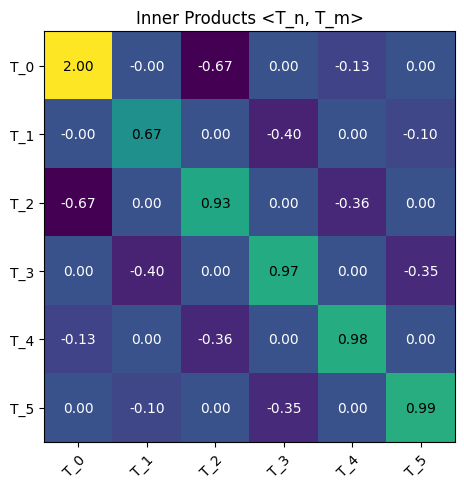

In [89]:
# show the orthogonality of chebyshev polynomials
from scipy.integrate import quad
from scipy.special import chebyt
from scipy.special import eval_chebyt
from scipy.special import eval_legendre

def chebyshev_inner_product(n, m):
    """
    Compute the inner product of T_n(x) and T_m(x) over the interval [-1, 1].
    """
    # The inner product of T_n(x) and T_m(x) is given by:
    # <T_n, T_m> = 2/(2n + 1) if n == m
    # <T_n, T_m> = 0 otherwise
    t = np.linspace(-1, 1, 1000)
    integrand = np.cos(n * np.arccos(t)) * np.cos(m * np.arccos(t))
    inner_product = simpson(integrand, t)
    
    return inner_product

def demonstrate_chebyshev_orthogonality(max_degree=5):
    fig, ax = plt.subplots(figsize=(5, 5))
    inner_product_matrix = np.zeros((max_degree+1, max_degree+1))
    for n in range(max_degree+1):
        for m in range(max_degree+1):
            inner_product_matrix[n, m] = chebyshev_inner_product(n, m)
            
    im = ax.imshow(inner_product_matrix, cmap='viridis')
    ax.set_xticks(np.arange(max_degree+1))
    ax.set_yticks(np.arange(max_degree+1))
    ax.set_xticklabels([f"T_{n}" for n in range(max_degree+1)])
    ax.set_yticklabels([f"T_{n}" for n in range(max_degree+1)])
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    for i in range(max_degree+1):
        for j in range(max_degree+1):
            if i!=j:
                color = "w"
            else:
                color = "k"
            text = ax.text(j, i, f"{inner_product_matrix[i, j]:.2f}",
                           ha="center", va="center", color=color)
    
    
    ax.set_title("Inner Products <T_n, T_m>")
    fig.tight_layout()
    plt.show()

# Example usage:
if __name__ == "__main__":
    demonstrate_chebyshev_orthogonality(max_degree=5)

### Create 2D stanford bunny point cloud and normalize to [-1,1]

In [70]:
def slice_mesh_with_plane(mesh, plane_origin, plane_normal):
    """
    Slice a mesh with a plane and return the intersection points.
    :param mesh: open3d.geometry.TriangleMesh
    :param plane_origin: Origin of the slicing plane
    :param plane_normal: Normal vector of the slicing plane
    :return: numpy.ndarray of intersection points
    """
    # Create the plane equation: ax + by + cz + d = 0
    plane_normal = plane_normal / np.linalg.norm(plane_normal)
    d = -np.dot(plane_normal, plane_origin)

    # Collect intersection points
    intersection_points = []
    triangles = np.asarray(mesh.triangles)
    vertices = np.asarray(mesh.vertices)

    for triangle in triangles:
        # Get the vertices of the triangle
        v0, v1, v2 = vertices[triangle]

        # Check intersection of edges with the plane
        edges = [(v0, v1), (v1, v2), (v2, v0)]
        for edge in edges:
            p1, p2 = edge
            # Compute distances to the plane
            dist1 = np.dot(plane_normal, p1) + d
            dist2 = np.dot(plane_normal, p2) + d

            # If the edge intersects the plane
            if dist1 * dist2 < 0:  # Opposite signs => intersection
                t = dist1 / (dist1 - dist2)  # Parametric distance to intersection
                intersection_point = p1 + t * (p2 - p1)
                intersection_points.append(intersection_point)

    return np.array(intersection_points)

In [ ]:
# Load the Stanford Bunny mesh
bunny = o3d.data.BunnyMesh()
mesh = o3d.io.read_triangle_mesh(bunny.path)
# mesh = mesh.subdivide_midpoint(number_of_iterations=1)
mesh.compute_vertex_normals()

# Define the slicing plane (e.g., z = 0.05)
plane_origin = np.array([0, 0, 0])  # A point on the plane
plane_normal = np.array([0, 0, 1])    # Plane normal (z-direction)

# Compute the intersection points
slice_points = slice_mesh_with_plane(mesh, plane_origin, plane_normal)

# Convert the slice to a 2D point cloud (x, y)
points = np.asarray(slice_points)
point_cloud_2d = points[:, :2]  # Ignore z-coordinate for 2D

# visualize the 2D point cloud
plt.figure()
plt.scatter(point_cloud_2d[:, 0], point_cloud_2d[:, 1], s=1)
plt.axis('equal')
plt.show()

In [ ]:
# Normalize the point cloud to [-1, 1]
pcl = point_cloud_2d
pcl = (pcl - pcl.min(axis=0)) / (pcl.max(axis=0) - pcl.min(axis=0))
pcl = 2 * pcl - 1
pcl = pcl * 0.9 # Scale the point cloud

# Visualize the normalized point cloud
plt.figure()
plt.scatter(pcl[:, 0], pcl[:, 1], s=1)
plt.axis('equal')
plt.show()

print(pcl.shape)


In [ ]:
def generate_monomials(X, degree):
    """
    Generate monomials up to a given degree for d-dimensional points.

    Parameters:
        X (ndarray): An array of shape (N, d) representing the point cloud.
        degree (int): The maximum degree of the monomials.

    Returns:
        ndarray: Monomial matrix of shape (N, M).
    """
    N, d = X.shape
    exponents = []
    # Generate all multi-indices with total degree up to 'degree'
    for total_degree in range(degree + 1):
        for exps in combinations_with_replacement(range(d), total_degree):
            exp = np.zeros(d, dtype=int)
            for var in exps:
                exp[var] += 1
            exponents.append(exp)
    print(exponents)
    M = len(exponents)
    print(f'Number of monomials: {M}') # Number of polynomials: n1 + n2 + ... + n_d = degree; degree + (d-1) choose (d-1); (d-1) number of dividers for an array in space R^d.
    monomials = np.ones((N, M))
    for i, exp in enumerate(exponents):
        print(exp)
        monomials[:, i] = np.prod(X ** exp, axis=1) # x1^exp1 * x2^exp2 * ... * xd^expd. e.g. x1^2 * x2^3 * x3^1 \in R^3
    return monomials

X = np.linspace(-1, 1, 1000).reshape(-1, 1)
Y = np.linspace(-1, 1, 1000).reshape(-1, 1)
X, Y = np.meshgrid(X, Y)
X = np.stack([X.flatten(), Y.flatten()], axis=1)
print(X.shape)
monomials = generate_monomials(X, 3)
for i in range(10):
    plt.figure()
    plt.imshow(monomials[:, i].reshape(1000, 1000))
    plt.colorbar()
    plt.axis('off')
    plt.title(f'Monomial {i}')



In [ ]:
def generate_chebyshev_polynomials(X, degree):
    """
    Generate Chebyshev polynomials up to a given degree for d-dimensional points.

    Parameters:
        X (ndarray): An array of shape (N, d) representing the d-dimensional point cloud.
        degree (int): The maximum degree of the polynomials.

    Returns:
        ndarray: Chebyshev polynomial matrix of shape (N, M).
    """
    N, d = X.shape
    exponents = []
    # Generate all multi-indices with total degree up to 'degree'
    for total_degree in range(degree + 1):
        for exps in combinations_with_replacement(range(d), total_degree):
            exp = np.zeros(d, dtype=int)
            for var in exps:
                exp[var] += 1
            exponents.append(exp)
    M = len(exponents)
    print(f'Number of Chebyshev polynomials: {M}') # Number of polynomials: n1 + n2 + ... + n_d = degree; degree + d choose d; d number of dividers for an array in space R^d.
    cheby_polynomials = np.ones((N, M))
    for i, exp in enumerate(exponents):
        cheby_polynomials[:, i] = np.prod(np.cos(exp * np.arccos(X)), axis=1)
    return cheby_polynomials

X = np.linspace(-1, 1, 1000).reshape(-1, 1)
Y = np.linspace(-1, 1, 1000).reshape(-1, 1)
X, Y = np.meshgrid(X, Y)
X = np.stack([X.flatten(), Y.flatten()], axis=1)
print(X.shape)
monomials = generate_chebyshev_polynomials(X, 3)
for i in range(10):
    plt.figure()
    plt.imshow(monomials[:, i].reshape(1000, 1000))
    plt.colorbar()
    plt.axis('off')
    plt.title(f'Monomial {i}')


In [ ]:
def generate_pesudo_chebyshev_polynomials(X, degree):
    """
    Generate pseudo Chebyshev polynomials up to a given degree for d-dimensional points.

    Parameters:
        X (ndarray): An array of shape (N, d) representing the d-dimensional point cloud.
        degree (int): The maximum degree of the polynomials.

    Returns:
        ndarray: Pseudo Chebyshev polynomial matrix of shape (N, M).
    """
    N, d = X.shape
    exponents = []
    # Generate all multi-indices with total degree up to 'degree'
    for total_degree in range(degree + 1):
        for exps in combinations_with_replacement(range(d), total_degree):
            exp = np.zeros(d, dtype=int)
            for var in exps:
                exp[var] += 1
            exponents.append(exp)
    M = len(exponents)
    print(f'Number of pseudo Chebyshev polynomials: {M}') # Number of polynomials: n1 + n2 + ... + n_d = degree; degree + d choose d; d number of dividers for an array in space R^d.
    pseudo_cheby_polynomials = np.ones((N, M))
    for i, exp in enumerate(exponents):
        pseudo_cheby_polynomials[:, i] = np.prod(np.cos((exp + 0.5) * np.arccos(X)), axis=1)
    return pseudo_cheby_polynomials



X = np.linspace(-1, 1, 1000).reshape(-1, 1)
Y = np.linspace(-1, 1, 1000).reshape(-1, 1)
X, Y = np.meshgrid(X, Y)
X = np.stack([X.flatten(), Y.flatten()], axis=1)
print(X.shape)
monomials = generate_pesudo_chebyshev_polynomials(X, 3)
for i in range(10):
    plt.figure()
    plt.imshow(monomials[:, i].reshape(1000, 1000))
    plt.colorbar()
    plt.axis('off')
    plt.title(f'Monomial {i}')

(40000, 2)
Number of Daubechies wavelets: 169


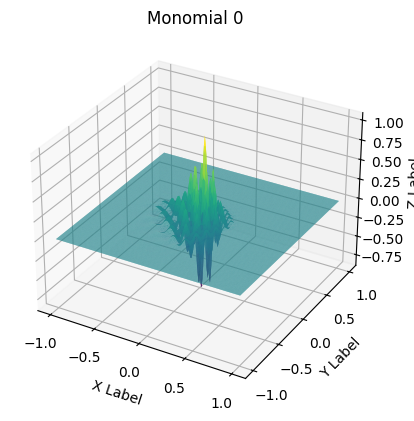

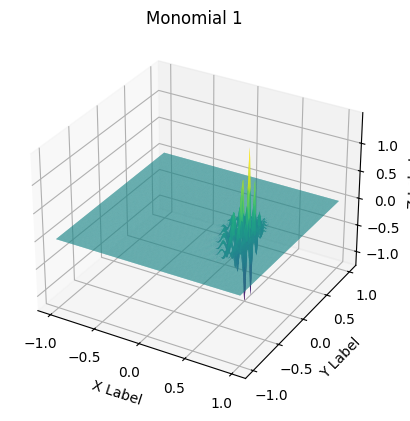

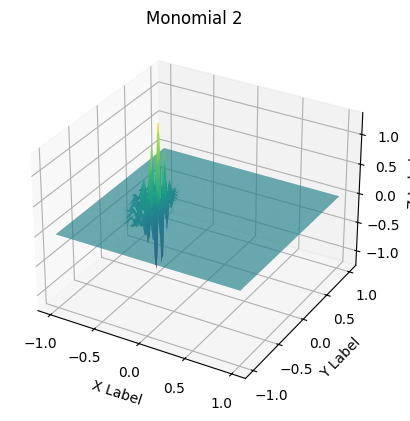

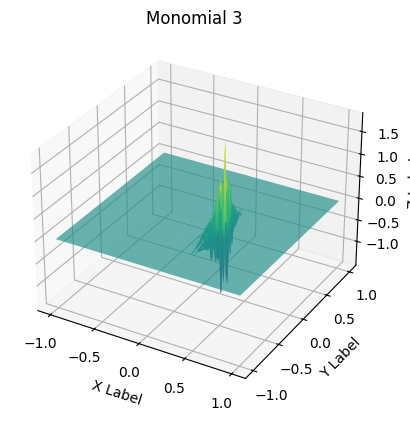

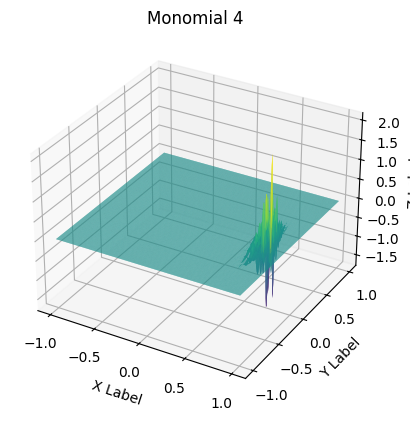

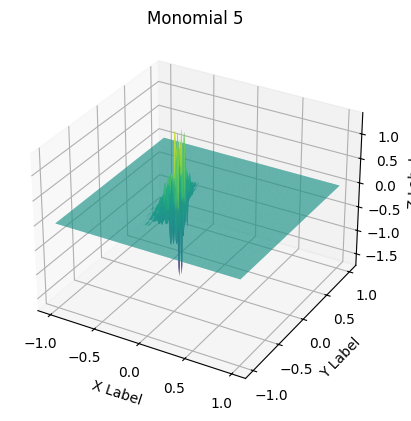

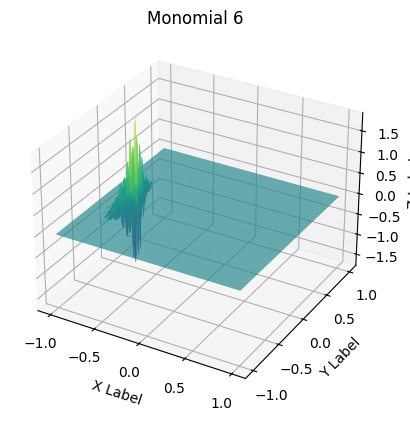

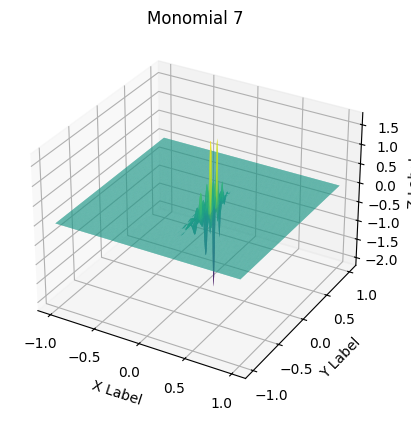

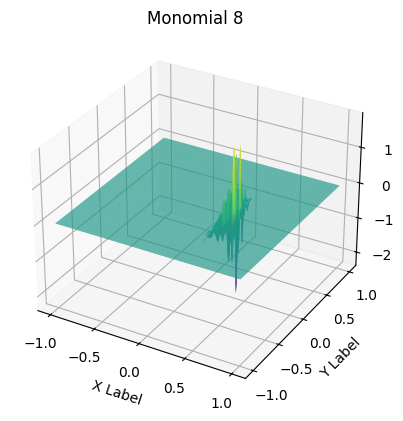

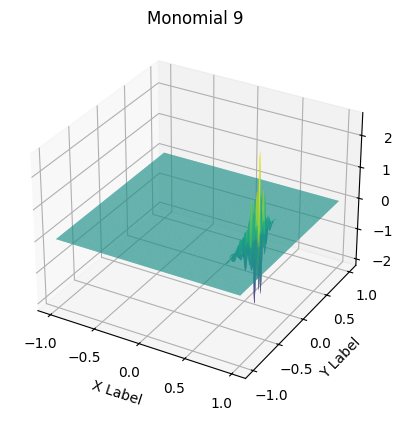

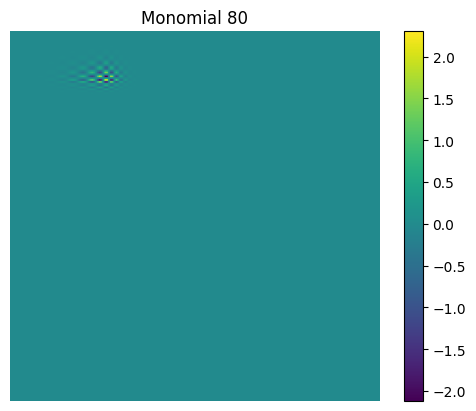

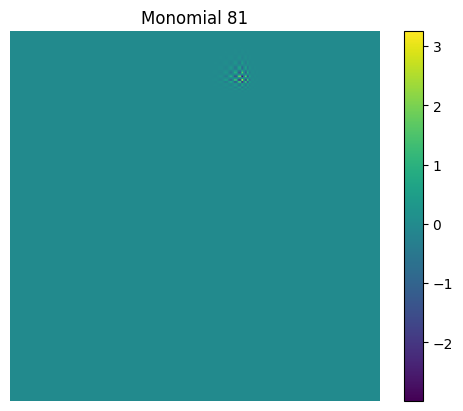

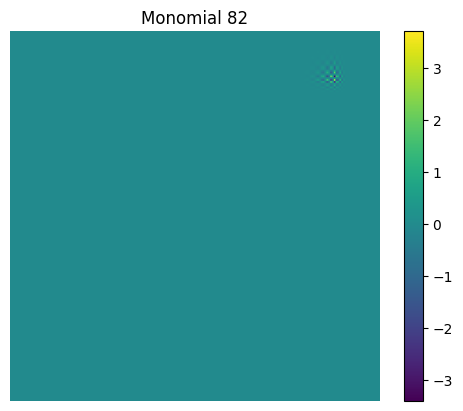

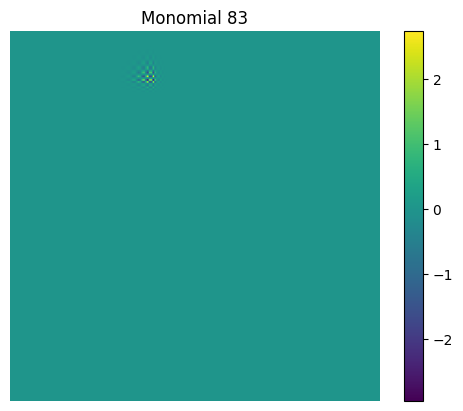

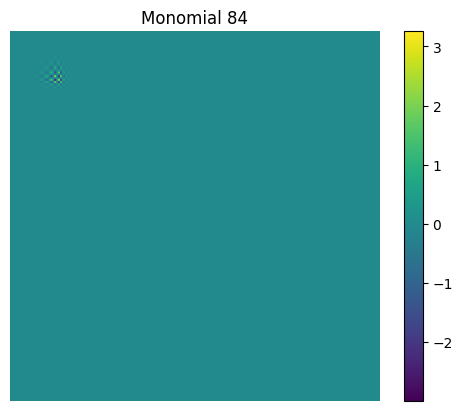

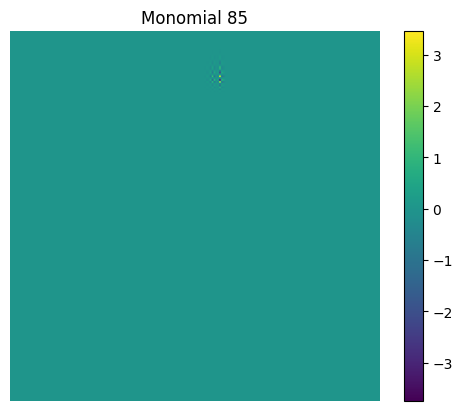

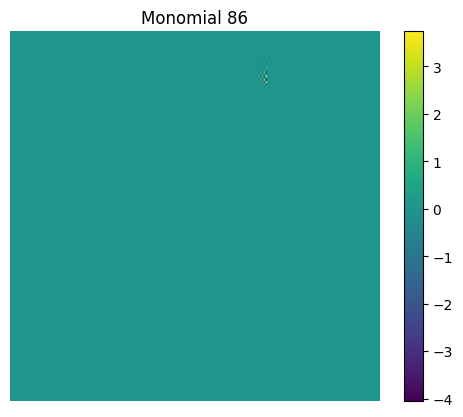

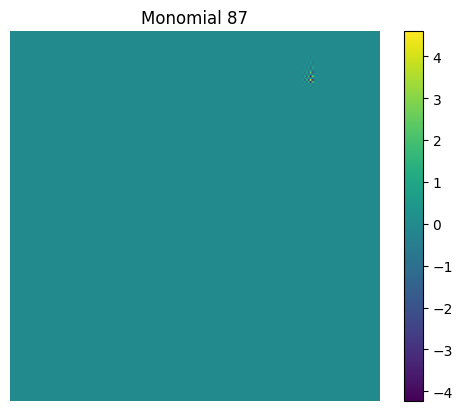

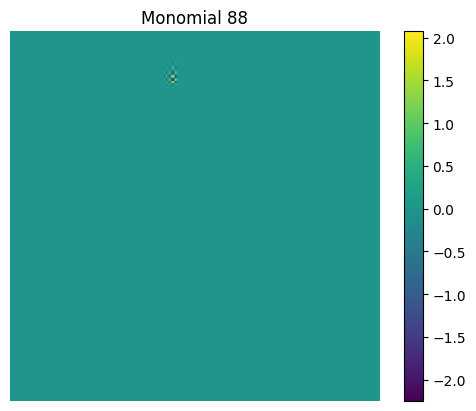

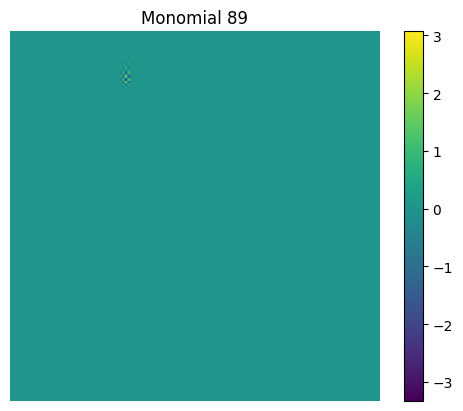

In [84]:
def generate_db_wavelets(X, degree, wavelet_name="db10", level=10, domain=(-1, 1)):
    """
    Generate Daubechies wavelets up to a given degree for d-dimensional points.

    Parameters:
        X (ndarray): An array of shape (N, d) representing the d-dimensional point cloud.
        degree (int): The maximum degree of the wavelets.
        wavelet_name (str): The name of the Daubechies wavelet.
        level (int): The level of the wavelet.
        
    Returns:
        ndarray: Daubechies wavelet matrix of shape (N, M).
    """
    N, d = X.shape
    
    wavelet = pywt.Wavelet(wavelet_name)
    phi, psi, x = wavelet.wavefun(level=level)
    
    # normalize x into domain
    # psi = psi * ((x[-1] - x[0]) / (domain[1] - domain[0]))**0.5
    x = (x - x[0]) / (x[-1] - x[0]) * (domain[1] - domain[0]) + domain[0]
    
    def psi_jk(t, base_psi, base_x, j, k):
        scaled_shifted_arg = (2**j) * t - k 
        psi_values = np.interp(scaled_shifted_arg, base_x, base_psi, left=0, right=0)
        return (2.0**(j/2)) * psi_values
    
    jk_pairs = [(0, 0)]
    for j in range(1, degree + 1):
        jk_pairs.extend([(j, (1 + 2*k)) for k in range(j)])
        jk_pairs.extend([(j, -(1 + 2*k)) for k in range(j)])
    
    # Create a grid of the index over the d dimensional jk_pairs
    didx_jk_pairs = np.meshgrid(*[range(len(jk_pairs)) for _ in range(d)])
    didx_jk_pairs = np.stack([didx_jk.flatten() for didx_jk in didx_jk_pairs], axis=1)
        
    M = len(jk_pairs)**d
    print(f'Number of Daubechies wavelets: {M}') # Number of polynomials: n1 + n2 + ... + n_d = degree; degree + d choose d; d number of dividers for an array in space R^d.
    assert M == len(didx_jk_pairs)
    wavelets = np.ones((N, M))
    for i, didx in enumerate(didx_jk_pairs):
        wavelets[:, i] = np.prod([psi_jk(X[:, j], psi, x, *jk_pairs[didx[j]]) for j in range(d)], axis=0)
        
    return wavelets

X = np.linspace(-1, 1, 200).reshape(-1, 1)
Y = np.linspace(-1, 1, 200).reshape(-1, 1)
X, Y = np.meshgrid(X, Y)
X = np.stack([X.flatten(), Y.flatten()], axis=1)
print(X.shape)
monomials = generate_db_wavelets(X, 3)
for i in range(10):
    # plot the surface of the wavelets in 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_trisurf(X[:, 0], X[:, 1], monomials[:, i], cmap='viridis')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.title(f'Monomial {i}')
    plt.show()
    
for i in range(80, 90):
    plt.figure()
    plt.imshow(monomials[:, i].reshape(200, 200))
    plt.colorbar()
    plt.axis('off')
    plt.title(f'Monomial {i}')

In [ ]:
import pywt
import matplotlib.pyplot as plt
import numpy as np
import torch

wavelet = pywt.Wavelet('db4')
print(wavelet)
# plot wavelet as a function of x

phi, psi, x = wavelet.wavefun(level=8) # level: subsampling levels. Subdivide each interval into half 5 times: n_x = 2*n_{x-1} - 1
print(phi.shape, psi.shape, x.shape, x)
plt.plot(x, phi, label='phi')
plt.plot(x, psi, label='psi')
plt.legend()
plt.show()

def linear_interpolate_1d(x_query, x_support, y_support):
    """
    Piecewise-linear interpolation of y_support vs x_support at the points x_query.

    x_query:   shape (B, N)
    x_support: shape (S,) - S support points
    y_support: shape (S,) - S function values

    returns: interpolated_y of shape (B, N)
    """
    # Make sure x_support is sorted
    # (wavefun typically returns x_vals sorted, but let's confirm.)
    indices = torch.searchsorted(x_support, x_query.clamp(min=x_support[0], max=x_support[-1]))
    # clamp to valid range
    indices = torch.clamp(indices, 1, len(x_support)-1)

    # x_{i-1}, x_i
    x0 = x_support[indices-1]
    x1 = x_support[indices]
    # y_{i-1}, y_i
    y0 = y_support[indices-1]
    y1 = y_support[indices]

    # linear interpolation factor
    alpha = (x_query - x0) / (x1 - x0 + 1e-12)
    return y0 + alpha * (y1 - y0)

def generate_daubechies_wavelets_sequence_batch(
    X,               # shape (B, N) for 1D
    wavelet_name="db4",
    j_values=(0,1,2),
    k_values=(-2,-1,0,1,2), 
    level=8
):
    """
    Evaluate Daubechies wavelet psi_{j,k}(x) for each (j,k), 
    then sum over x, giving a feature vector of shape (B, M).
    Here M = (# of j_values) * (# of k_values).

    Return shape: (B, M)
    """
    # Get sampled wavelet
    _, psi_vals, x_support = pywt.Wavelet(wavelet_name).wavefun(level=level)
    # wavefun returns (phi, psi, x), but we only need psi, x for wavelet
    psi_vals = torch.tensor(psi_vals, dtype=torch.float32)
    x_support= torch.tensor(x_support, dtype=torch.float32)
    # normalize x_support to [-1, 1]
    x_support = 2 * (x_support - x_support[0]) / (x_support[-1] - x_support[0]) - 1

    B, N = X.shape
    device = X.device

    # Move support & wavelet values to device if needed
    psi_vals    = psi_vals.to(device)
    x_support   = x_support.to(device)

    # Prepare the output (B, M)
    M = len(j_values) * len(k_values)
    wavelet_features = torch.zeros((B, M), device=device)

    # index for placing wavelet features
    m_idx = 0
    for j in j_values:
        for k in k_values:
            # Evaluate psi_{j,k}(x_i)
            # shape of wavelet_jk: (B, N)
            wavelet_jk =(2**(-0.5*j)) * linear_interpolate_1d(2**(-j) * X - k, x_support, psi_vals)
            print(2**j, k)
            plt.plot(X[0], wavelet_jk[0])
            plt.xlim(-5, 5)
            plt.ylim(-2, 2)
            plt.show()
            # E.g. sum over N to get a single scalar per batch
            wavelet_features[:, m_idx] = wavelet_jk.sum(dim=1) / N
            m_idx += 1
    print(wavelet_features.shape)
    return wavelet_features

X = np.linspace(-2, 2, 2000).reshape(1, -1)
X = torch.tensor(X, dtype=torch.float32)
generate_daubechies_wavelets_sequence_batch(X, wavelet_name="db4", j_values=np.linspace(-1,1, 10), k_values=np.linspace(-1,1, 10), level=8)

# wavelet = pywt.ContinuousWavelet('cmor')
# print(wavelet)
# psi, x = wavelet.wavefun(level=10) # level: subsampling levels. 2^level points
# print(psi.shape, x.shape)
# plt.plot(x, psi)
# plt.show()

### Cholesky inverse version

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from scipy.linalg import cho_factor, cho_solve

def generate_monomials(X, degree):
    """
    Generate monomials up to a given degree for d-dimensional points.

    Parameters:
        X (ndarray): An array of shape (N, d) representing the point cloud.
        degree (int): The maximum degree of the monomials.

    Returns:
        ndarray: Monomial matrix of shape (N, M).
    """
    N, d = X.shape
    exponents = []
    # Generate all multi-indices with total degree up to 'degree'
    for total_degree in range(degree + 1):
        for exps in combinations_with_replacement(range(d), total_degree):
            exp = np.zeros(d, dtype=int)
            for var in exps:
                exp[var] += 1
            exponents.append(exp)
    M = len(exponents)
    print(f'Number of monomials: {M}') # Number of polynomials: n1 + n2 + ... + n_d = degree; degree + (d-1) choose (d-1); (d-1) number of dividers for an array in space R^d.
    monomials = np.ones((N, M))
    for i, exp in enumerate(exponents):
        monomials[:, i] = np.prod(X ** exp, axis=1) # x1^exp1 * x2^exp2 * ... * xd^expd. e.g. x1^2 * x2^3 * x3^1 \in R^3
    return monomials

def generate_chebyshev_polynomials(X, degree):
    """
    Generate Chebyshev polynomials up to a given degree for d-dimensional points.

    Parameters:
        X (ndarray): An array of shape (N, d) representing the d-dimensional point cloud.
        degree (int): The maximum degree of the polynomials.

    Returns:
        ndarray: Chebyshev polynomial matrix of shape (N, M).
    """
    N, d = X.shape
    exponents = []
    # Generate all multi-indices with total degree up to 'degree'
    for total_degree in range(degree + 1):
        for exps in combinations_with_replacement(range(d), total_degree):
            exp = np.zeros(d, dtype=int)
            for var in exps:
                exp[var] += 1
            exponents.append(exp)
    M = len(exponents)
    print(f'Number of Chebyshev polynomials: {M}') # Number of polynomials: n1 + n2 + ... + n_d = degree; degree + d choose d; d number of dividers for an array in space R^d.
    cheby_polynomials = np.ones((N, M))
    for i, exp in enumerate(exponents):
        cheby_polynomials[:, i] = np.prod(np.cos(exp * np.arccos(X)), axis=1)
    return cheby_polynomials



def generate_db_wavelets(X, degree, wavelet_name="db4", level=10, domain=(-1, 1)):
    """
    Generate Daubechies wavelets up to a given degree for d-dimensional points.

    Parameters:
        X (ndarray): An array of shape (N, d) representing the d-dimensional point cloud.
        degree (int): The maximum degree of the wavelets.
        wavelet_name (str): The name of the Daubechies wavelet.
        level (int): The level of the wavelet.
        
    Returns:
        ndarray: Daubechies wavelet matrix of shape (N, M).
    """
    N, d = X.shape
    
    wavelet = pywt.Wavelet(wavelet_name)
    phi, psi, x = wavelet.wavefun(level=level)
    
    # normalize x into domain
    psi = psi * ((x[-1] - x[0]) / (domain[1] - domain[0]))**0.5
    x = (x - x[0]) / (x[-1] - x[0]) * (domain[1] - domain[0]) + domain[0]
    
    def psi_jk(t, base_psi, base_x, j, k):
        scaled_shifted_arg = (2**j) * t - k 
        psi_values = np.interp(scaled_shifted_arg, base_x, base_psi, left=0, right=0)
        return (2.0**(j/2)) * psi_values
    
    jk_pairs = [(0, 0)]
    for j in range(1, degree + 1):
        jk_pairs.extend([(j, (1 + 2*k)) for k in range(j)])
        jk_pairs.extend([(j, -(1 + 2*k)) for k in range(j)])
    
    # Create a grid of the index over the d dimensional jk_pairs
    didx_jk_pairs = np.meshgrid(*[range(len(jk_pairs)) for _ in range(d)])
    didx_jk_pairs = np.stack([didx_jk.flatten() for didx_jk in didx_jk_pairs], axis=1)
        
    M = len(jk_pairs)**d
    assert M == len(didx_jk_pairs)
    wavelets = np.ones((N, M))
    for i, didx in enumerate(didx_jk_pairs):
        wavelets[:, i] = np.prod([psi_jk(X[:, j], psi, x, *jk_pairs[didx[j]]) for j in range(d)], axis=0)
        
    return wavelets



In [ ]:

def approximate_density(X, degree, poly=generate_monomials, grid_size=100, reg=1e-10, ax_lim=1.0):
    """
    Approximate the density on a grid using the Christoffel function.

    Parameters:
        X (ndarray): The original point cloud of shape (N, d).
        degree (int): The maximum degree of the polynomials.
        grid_size (int): The size of the grid for visualization.

    Returns:
        ndarray: Grid of x coordinates.
        ndarray: Grid of y coordinates.
        ndarray: Estimated density values on the grid.
    """
    N, d = X.shape
    # Generate monomials at data points
    M_X = poly(X, degree)
    # Compute empirical covariance matrix
    time_start = time.time()
    S = (M_X.T @ M_X) / N
    print(f'Time for covariance computation: {time.time() - time_start:.2f}s')
    # Invert covariance matrix with regularization
    M = S.shape[0]
    S_reg = S + reg * np.eye(M)
    # Use Cholesky decomposition for numerical stability
    time_start = time.time()
    c, lower = cho_factor(S_reg)
    print(f'Time for Cholesky decomposition: {time.time() - time_start:.2f}s')
    time_start = time.time()
    S_inv = cho_solve((c, lower), np.eye(M))
    print(f'Time for Cholesky inverse computation: {time.time() - time_start:.2f}s')
    # Create a grid over the domain
    # x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
    # y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
    # xx, yy = np.meshgrid(np.linspace(-ax_lim, ax_lim, grid_size),
    #                      np.linspace(-ax_lim, ax_lim, grid_size))
    # grid_points = np.column_stack([xx.ravel(), yy.ravel()])
    r = [np.linspace(-ax_lim, ax_lim, grid_size) for _ in range(d)]
    grids =np.meshgrid(*r)
    grid_points = np.column_stack([grid.ravel() for grid in grids])
    # Compute monomials at grid points
    M_grid = poly(grid_points, degree)
    # Compute Christoffel function at grid points
    time_start = time.time()
    # kappas = np.einsum('ij,jk,ik->i', M_grid, S_inv, M_grid)
    kappas = np.sum(M_grid @ S_inv * M_grid, axis=1)
    print(f'Time for Christoffel function computation: {time.time() - time_start:.2f}s')
    # Compute density estimates
    densities = 1 / kappas
    densities = densities.reshape((grid_size, grid_size))
    return grids, densities


In [ ]:
# Set the degree of polynomials
degree = 30
# Approximate density
grids, density = approximate_density(pcl, degree, poly=generate_monomials, grid_size=1000, reg=1e-12)
print(density.max(), density.min())
# Plot the level sets of the density
plt.figure(figsize=(15,15))
plt.contourf(*grids, density, levels=10)
plt.scatter(pcl[:, 0], pcl[:, 1], s=0.01, color='white')
plt.legend()
plt.title('Density Estimation (Monomials)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
# Set the degree of polynomials
degree = 21
# Approximate density
grids, density = approximate_density(pcl, degree, poly=generate_chebyshev_polynomials, grid_size=1000, reg=1e-12)
# print(density.max(), density.min())
# Plot the level sets of the density
plt.figure(figsize=(15,15))
plt.contourf(*grids, density, levels=10)
plt.scatter(pcl[:, 0], pcl[:, 1], s=0.01, color='white')
plt.legend()
# plt.colorbar()
plt.title('Density Estimation (Chebyshev Polynomials)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
# Set the degree of polynomials
degree = 21
# Approximate density
grids, density = approximate_density(pcl, degree, poly=generate_db_wavelets, grid_size=1000, reg=1e-12)
# print(density.max(), density.min())
# Plot the level sets of the density
plt.figure(figsize=(15,15))
plt.contourf(*grids, density, levels=10)
plt.scatter(pcl[:, 0], pcl[:, 1], s=0.01, color='white')
plt.legend()
# plt.colorbar()
plt.title('Density Estimation (Chebyshev Polynomials)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()